# Build an end to end solution
Work with the explore notebook to build and end-to-end solution. 

Have a study of possible optimizations.

In [1]:
%matplotlib inline
#%matplotlib notebook
%load_ext version_information
%load_ext autoreload


In [2]:
from collections import namedtuple
import datetime
import os
from pprint import pprint
import sys
import warnings

warnings.simplefilter("ignore")
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import spacepy.datamodel as dm
import spacepy.plot as spp
import spacepy.time as spt
import spacepy.pycdf as pycdf
import spacepy.toolbox as tb
import spacepy.pycdf as pycdf
import path
import tqdm
import pandas as pd
import xarray as xr
from mpl_toolkits.mplot3d import Axes3D
from scipy.linalg import norm
from scipy import constants

import spiceypy as spice

%version_information matplotlib, numpy, spacepy, pandas, spiceypy

Software versions
Python 3.6.2 64bit [GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
IPython 6.1.0
OS Darwin 15.6.0 x86_64 i386 64bit
matplotlib 2.0.2
numpy 1.11.3
spacepy UNRELEASED
pandas 0.20.1
spiceypy 2.0.0
Fri Jul 21 13:53:39 2017 MDT

In [3]:
plt.rcParams['figure.figsize'] = [10, 6]
plt.rcParams['savefig.dpi'] = plt.rcParams['figure.dpi'] # 72
%config InlineBackend.figure_format = 'retina'

In [4]:
EARTH_RAD = 6378137/1e3 # WGS84 km

WGS84_A = 6378.1370    #           // semi-major axis of earth (equatorial radius) in km
WGS84_A2 = 40680631.59076899 #      // WGS84_A * WGS84_A (km^2)
WGS84_A2mB2 = 272331.6066819355 #      // WGS84_A2 - WGS84_B2 (km^2)
WGS84_B = 6356.7523142      #      // semi-minor axis of earth (polar radius) in km ( derived from b=a(1-f) )
WGS84_B2 = 40408299.98408706  #     // WGS84_B * WGS84_B (km^2)
WGS84_A2mB2 = 272331.6066819355 #      // WGS84_A2 - WGS84_B2 (km^2)

In [5]:

masses = {'H':938.2720813e6, 'He':3728.401e6, 'O':14899.17e6}  # eV/c**2

def kms_to_c(kms):
    """
    change km/s into a fraction of c
    """
    return kms*1e3/constants.c

print(kms_to_c(3e8/1e3), kms_to_c(10/1e3))

def kms_to_e(kms, species='H'):
    """
    change km/s into energy for the species
    """
    return np.sign(kms)*0.5*masses[species]*kms_to_c(kms)**2
    
print(kms_to_e(10, 'H'), kms_to_e(10, 'He'), kms_to_e(10, 'O'))
print(kms_to_e(-10, 'H'), kms_to_e(-10, 'He'), kms_to_e(-10, 'O'))


def makeFullTimes_Ele(L1cdf, TagTimes):
    """
    go through and make the full time arrays
    """
    # raw read the Epoch!!  This is faster and in milliseconds so no conversion needed
    epoch16 = L1cdf.raw_var('Epoch_Elc_Cntr_e')[...]
    TagTimes['Epoch_Ele'] = dm.dmarray([pycdf.lib.epoch16_to_epoch(v) for v in epoch16])
    TagTimes['Epoch_Ele'].attrs = L1cdf['Epoch_Elc_Cntr_e'].attrs.copy()
    # (3879,)

    # if they are actually all the same no need to cycle through here
    if (L1cdf['FRAME_subtime'][:, 0, 0] != L1cdf['FRAME_subtime'][:, 0, 0][0]).any():
        raise(NotImplementedError("L1cdf['FRAME_subtime'] has different values, not sure what to do"))

    TagTimes['Epoch_Ele_FRAME_subtime'] = L1cdf['FRAME_subtime'][0, :, :].copy()
    # (16, 72)
    # L2cdf['FEDU'] CDF_REAL4 [3879, 5, 16, 72]
    ## multiply TagTimes['Epoch_Ele_FRAME_subtime'] by 1000 to make it a Epoch (milliseconds)
    TagTimes['Epoch_Ele_FRAME_subtime'] *= 1000

    ## make the full times as Epochs
    # Full times needs [epoch][sector][energy]  NO PIXEL!!
    # factor of 4 in time by not having it be [pixel] also (8 to 2 seconds)
    # also cdf is 140M smaller!!!
    TagTimes['Full_times_Ele'] = np.empty((L1cdf['Elc_Cntr_e'].shape[0],
                                           L1cdf['Elc_Cntr_e'].shape[2],
                                           L1cdf['Elc_Cntr_e'].shape[3]), dtype=np.float64)

    for ii, epoch in enumerate(TagTimes['Epoch_Ele']):
        TagTimes['Full_times_Ele'][ii] = epoch + TagTimes['Epoch_Ele_FRAME_subtime']


def makeFullTimes_Ion(L1cdf, TagTimes):
    """
    go through and make the full time arrays
    """
    # raw read the Epoch!!  This is faster and in milliseconds so no conversion needed
    epoch16 = L1cdf.raw_var('Epoch_Ion_Cntr_H')[...]
    # (3879,)
    TagTimes['Epoch_Ion'] = dm.dmarray([pycdf.lib.epoch16_to_epoch(v) for v in epoch16])
    TagTimes['Epoch_Ion'].attrs = L1cdf['Epoch_Ion_Cntr_H'].attrs.copy()

    # if they are actually all the same no need to cycle through here
    if (L1cdf['FRAME_subtime'][:, 0, 0] != L1cdf['FRAME_subtime'][:, 0, 0][0]).any():
        raise(NotImplementedError("L1cdf['FRAME_subtime'] has different values, not sure what to do"))

    TagTimes['Epoch_Ion_FRAME_subtime'] = L1cdf['FRAME_subtime'][0, :, :].copy()
    # (16, 72)
    # L2cdf['FEDU'] CDF_REAL4 [3879, 5, 16, 72]
    ## multiply TagTimes['Epoch_Ion_FRAME_subtime'] by 1000 to make it a Epoch (milliseconds)
    TagTimes['Epoch_Ion_FRAME_subtime'] *= 1000

    ## make the full times as Epochs
    # Full times needs [epoch][sector][energy]  NO PIXEL!!
    # factor of 4 in time by not having it be [pixel] also (8 to 2 seconds)
    # also cdf is 140M smaller!!!
    TagTimes['Full_times_Ion'] = np.empty((L1cdf['Ion_Cntr_H'].shape[0],
                                           L1cdf['Ion_Cntr_H'].shape[2],
                                           L1cdf['Ion_Cntr_H'].shape[3]), dtype=np.float64)

    for ii, epoch in enumerate(TagTimes['Epoch_Ion']):
        TagTimes['Full_times_Ion'][ii] = epoch + TagTimes['Epoch_Ion_FRAME_subtime']




1.0006922855944562 3.3356409519815205e-08
0.521984241926 2.07420279082 8.28878116783
-0.521984241926 -2.07420279082 -8.28878116783


In [6]:
def ET_to_ISO(et):
    """
    given spice ET return ISO representation
    """
    PICTUR = 'YYYY-MM-DDTHR:MN:SC.######'
    return spice.timout(et, PICTUR)

def get_var(fname, var):
    with pycdf.CDF(fname) as cdf:
        return cdf[var][...]

In [7]:
l1fname = 'rbspa_int_ect-hope-sci-L1_20161210_v1.1.0.cdf'
l2fname = 'rbspa_int_ect-hope-sci-L2_20161210_v5.2.0.cdf'
# l1 = dm.fromCDF(l1fname)
# l2 = dm.fromCDF('rbspa_int_ect-hope-sci-L2_20161210_v5.2.0.cdf')
# l2.tree(verbose=1)
with pycdf.CDF(l2fname) as cdf:
    tb.dictree(cdf, verbose=1)

+
|____Acquisition_Period (spacepy.pycdf.Var (7612,))
|____B_Calc_Ele (spacepy.pycdf.Var (4138,))
|____B_Calc_Ion (spacepy.pycdf.Var (3474,))
|____B_Eq_Ele (spacepy.pycdf.Var (4138,))
|____B_Eq_Ion (spacepy.pycdf.Var (3474,))
|____Detector_LABL (spacepy.pycdf.Var (5,))
|____ENERGY_Ele_DELTA (spacepy.pycdf.Var (4138, 72))
|____ENERGY_Ion_DELTA (spacepy.pycdf.Var (3474, 72))
|____ESA_Polarity (spacepy.pycdf.Var (7612,))
|____ESA_Sweep (spacepy.pycdf.Var (7612,))
|____ESA_Volt (spacepy.pycdf.Var (7612, 72))
|____ESA_Volt_LABL_1 (spacepy.pycdf.Var (72,))
|____Energy_Collapsed (spacepy.pycdf.Var (7612,))
|____Energy_LABL (spacepy.pycdf.Var (72,))
|____Epoch (spacepy.pycdf.Var (7612,))
|____Epoch_Ele (spacepy.pycdf.Var (4138,))
|____Epoch_Ele_DELTA (spacepy.pycdf.Var (4138,))
|____Epoch_Ion (spacepy.pycdf.Var (3474,))
|____Epoch_Ion_DELTA (spacepy.pycdf.Var (3474,))
|____FEDU (spacepy.pycdf.Var (4138, 5, 16, 72))
|____FHEDU (spacepy.pycdf.Var (3474, 5, 16, 72))
|____FLAGS (spacepy.pycdf.Var 

In [8]:
KINFO = namedtuple('KINFO', ('tkvrsn', 'kern', 'kinfo', 'totSPK'))
def load_kernels(kern, clearFirst=True):
    """
    load up the kernels we need
    """
    if clearFirst:
        spice.kclear()
    # load up the spice kernel
    tkvrsn = spice.tkvrsn("TOOLKIT")
    spice.furnsh(kern)
    kinfo = spice.kinfo(kern)
    totSPK = spice.ktotal('SPK')
    return KINFO(tkvrsn, kern, kinfo, totSPK)
print(load_kernels("package/20161210_kern.ker"))


KINFO(tkvrsn='CSPICE_N0066', kern='package/20161210_kern.ker', kinfo=('META', '', 0), totSPK=2)


## Get the time from the CDF into TAI for conversion to spice Ephermeris Time (ET)

In [9]:
def cdfepoch_to_et(epoch, verbose=False):
    """
    Given a CDF epoch return the spice ET
    
    Given a l2 cdf filename open it and pull out the RAW ion and electron times
    NOTE: this just gets the data not the attrs
    """
    if verbose:
        print('Epoch[0], {0}'.format(epoch[0]))
        print('Epoch[-1], {0}'.format(epoch[-1]))
    if isinstance(epoch[0], datetime.datetime):
        if verbose:
            print("Input was datetime")
        TAI = spt.Ticktock(epoch, 'UTC').TAI
    else:
        if verbose:
            print("Input was CDF epoch")
        TT = spt.Ticktock(epoch, 'CDF')
        if verbose:
            print('TT[0], {0}'.format(TT[0].UTC))
            print('TT[-1], {0}'.format(TT[-1].UTC))
        TAI = TT.TAI
    TAI -= 1325419200 # there just seems to be an issue in SPICE TAI
    if verbose:
        print('TAI[0], {0}'.format(TAI[0]))
        print('TAI[-1], {0}'.format(TAI[-1]))
    # get the ET from the TAI
    ET = np.asarray([spice.unitim( v, 'TAI', 'ET' ) for v in TAI])
    if verbose:
        print('ET[0], {0}    {1}'.format(ET[0], ET_to_ISO(ET[0])))
        print('ET[-1], {0}    {1}'.format(ET[-1], ET_to_ISO(ET[-1])))
    if verbose:
        # perform a check
        st0 = spice.utc2et((TT[0].UTC)[0].isoformat())
        st1 = ET[0]
        print('from ISO: {0}   From ET: {1}    Diff: {2}'.format(st0, st1, st0-st1))
    return ET

with pycdf.CDF(l2fname) as cdf:
    epoch_ion = cdf.raw_var('Epoch_Ion')[...]
    
ET = cdfepoch_to_et(epoch_ion, verbose=1)
ET[0:5]


Epoch[0], 63648547236389.0
Epoch[-1], 63648633540202.0
Input was CDF epoch
TT[0], [datetime.datetime(2016, 12, 10, 0, 0, 36, 389000)]
TT[-1], [datetime.datetime(2016, 12, 10, 23, 59, 0, 202004)]
TAI[0], 534600072.38899994
TAI[-1], 534686376.20200396
ET[0], 534600104.5723138    2016-12-10T00:00:36.388999
ET[-1], 534686408.3853442    2016-12-10T23:59:00.202003
from ISO: 534600104.57231385   From ET: 534600104.5723138    Diff: 5.960464477539063e-08


array([  5.34600105e+08,   5.34600127e+08,   5.34600150e+08,
         5.34600173e+08,   5.34600195e+08])

In [10]:
def cdffile_to_et(fname):
    """
    Given a HOPE L1 or L2 CDF filename return the spice ET
    
    Given a l2 cdf filename open it and pull out the RAW ion and electron times
    NOTE: this just gets the data not the attrs
    """
    l1keys = ('Epoch_Ion_Cntr_H', 'Epoch_Elc_Cntr_e')
    l2keys = ('Epoch_Ion', 'Epoch_Ele')
    # get the CDF epoch from the file
    epochs = {}
    with pycdf.CDF(fname) as cdf:
        if l1keys[0] in cdf:
            keys = l1keys
            raise(NotImplementedError("The L1 CDF epoch is 2 numbers"))
        else:
            keys = l2keys
        for k in keys:
            epochs[k] = cdf.raw_var(k)[...]
    ETs = {}
    for k in epochs:
        ETs[k] = cdfepoch_to_et(epochs[k])
    return ETs

ETs = cdffile_to_et(l2fname)
tb.dictree(ETs, verbose=1)
ETs['Epoch_Ion'][0:5] 

+
|____Epoch_Ele (numpy.ndarray (4138,))
|____Epoch_Ion (numpy.ndarray (3474,))


array([  5.34600105e+08,   5.34600127e+08,   5.34600150e+08,
         5.34600173e+08,   5.34600195e+08])

### Check that the time conversions were correct


In [11]:

ET_to_ISO(ETs['Epoch_Ion'][0])

'2016-12-10T00:00:36.388999'

In [12]:
print(ETs['Epoch_Ion'][0], ET_to_ISO(ETs['Epoch_Ion'][0]))
print(ETs['Epoch_Ion'][-1], ET_to_ISO(ETs['Epoch_Ion'][-1]))


534600104.572 2016-12-10T00:00:36.388999
534686408.385 2016-12-10T23:59:00.202003


## Get the positions and velocities for the Ion times

In [13]:
def get_pv(spicet, sat='RBSP_A'):
    """
    return the position, velocity, and light time for an array of spice ETs
    """
    positions = np.empty((len(spicet), 3), dtype=float)
    velocities = np.empty((len(spicet), 3), dtype=float)
    lightTimes = np.empty((len(spicet)), dtype=float)
    for ii, val in enumerate(tqdm.tqdm(spicet)):
        pv, lightTimes[ii] = spice.spkezr(sat, val, 'J2000', 'NONE', 'EARTH')
        positions[ii] = pv[:3]
        velocities[ii] = pv[3:]
    return positions, velocities, lightTimes

ETs = cdffile_to_et(l2fname)
DTs = get_var(l2fname, 'Epoch_Ion')

pos, vel, lt = get_pv(ETs['Epoch_Ion'])
    

100%|██████████| 3474/3474 [00:00<00:00, 21150.05it/s]


(-3, 3)

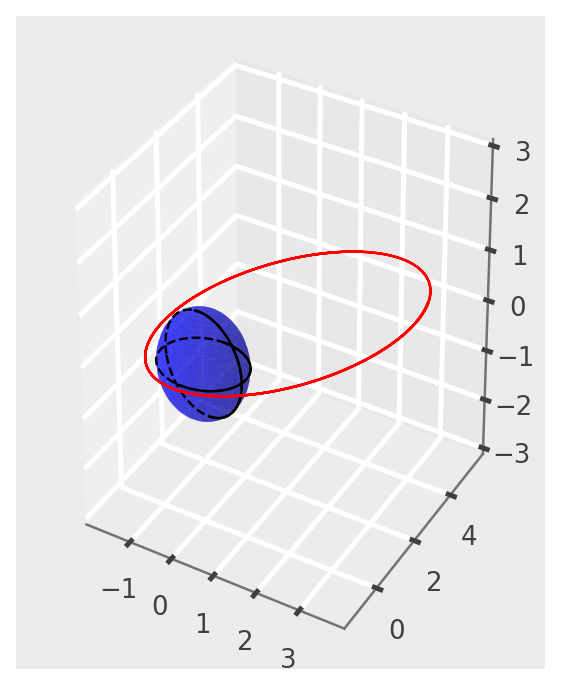

In [14]:
# 3d plot up the orbit
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.set_aspect('equal')

u = np.linspace(0, 2 * np.pi, 100)
v = np.linspace(0, np.pi, 100)

x = 1 * np.outer(np.cos(u), np.sin(v))
y = 1 * np.outer(np.sin(u), np.sin(v))
z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))
elev = 10.0
rot = 80.0 / 180 * np.pi
ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='b', linewidth=0, alpha=0.5)
#calculate vectors for "vertical" circle
a = np.array([-np.sin(elev / 180 * np.pi), 0, np.cos(elev / 180 * np.pi)])
b = np.array([0, 1, 0])
b = b * np.cos(rot) + np.cross(a, b) * np.sin(rot) + a * np.dot(a, b) * (1 - np.cos(rot))
ax.plot(np.sin(u),np.cos(u),0,color='k', linestyle = 'dashed')
horiz_front = np.linspace(0, np.pi, 100)
ax.plot(np.sin(horiz_front),np.cos(horiz_front),0,color='k')
vert_front = np.linspace(np.pi / 2, 3 * np.pi / 2, 100)
ax.plot(a[0] * np.sin(u) + b[0] * np.cos(u), b[1] * np.cos(u), a[2] * np.sin(u) + b[2] * np.cos(u),color='k', linestyle = 'dashed')
ax.plot(a[0] * np.sin(vert_front) + b[0] * np.cos(vert_front), b[1] * np.cos(vert_front), a[2] * np.sin(vert_front) + b[2] * np.cos(vert_front),color='k')

# ax.view_init(elev = elev, azim = 0)

ax.plot(pos[:,0]/WGS84_A, pos[:,1]/WGS84_A, pos[:,2]/WGS84_A, c='r')
ax.set_zlim(-3,3)
# ax.set_aspect('equal')

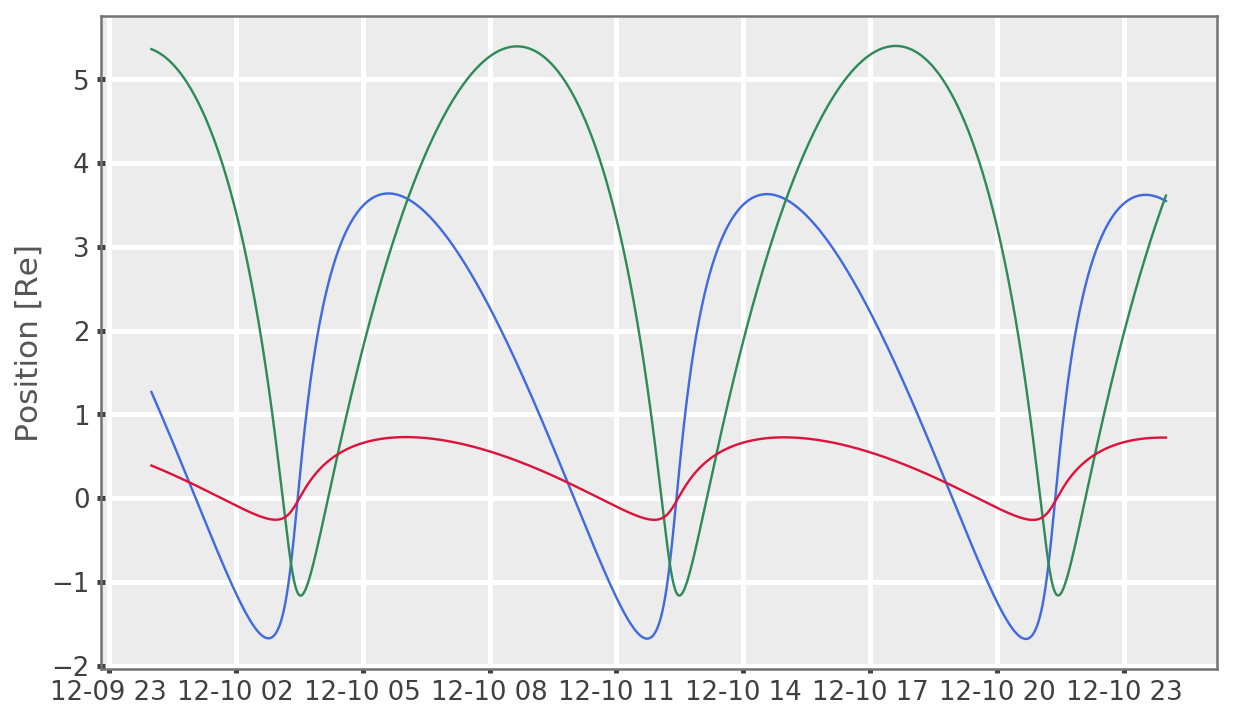

In [15]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1, sharex=True)
ax1.plot(DTs, pos/WGS84_A)
ax1.set_ylabel('Position [Re]')




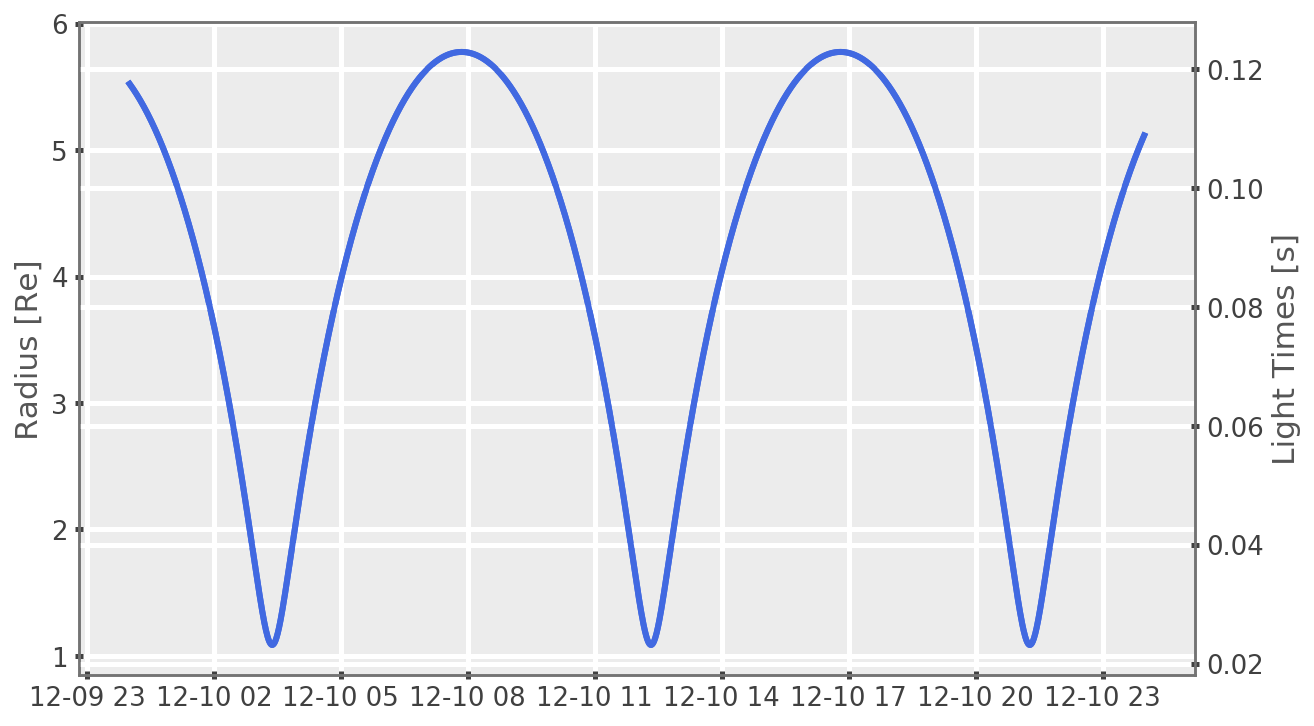

In [16]:
fig, ax1 = plt.subplots(ncols=1, nrows=1, sharex=True)

ax1.plot(DTs, norm(pos/WGS84_A, axis=1), lw=3)
ax1.set_ylabel('Radius [Re]')

ax2 = ax1.twinx()

ax2.plot(DTs, lt, lw=3)
ax2.set_ylabel('Light Times [s]')


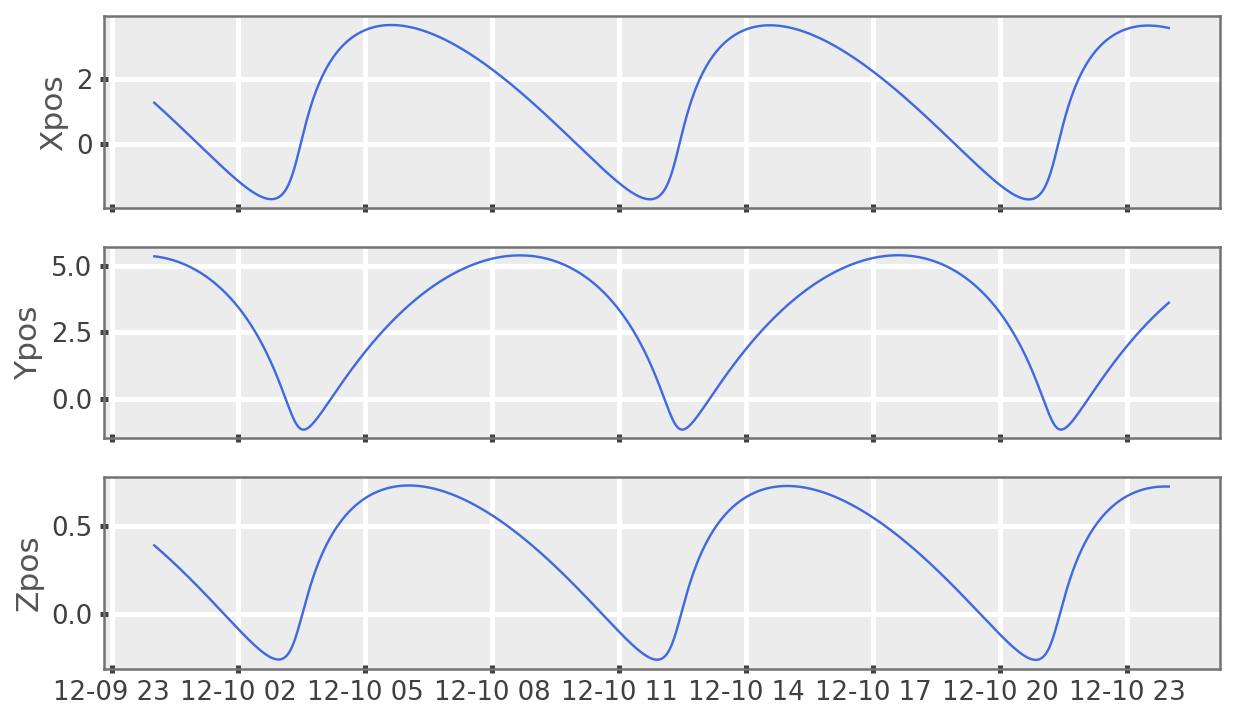

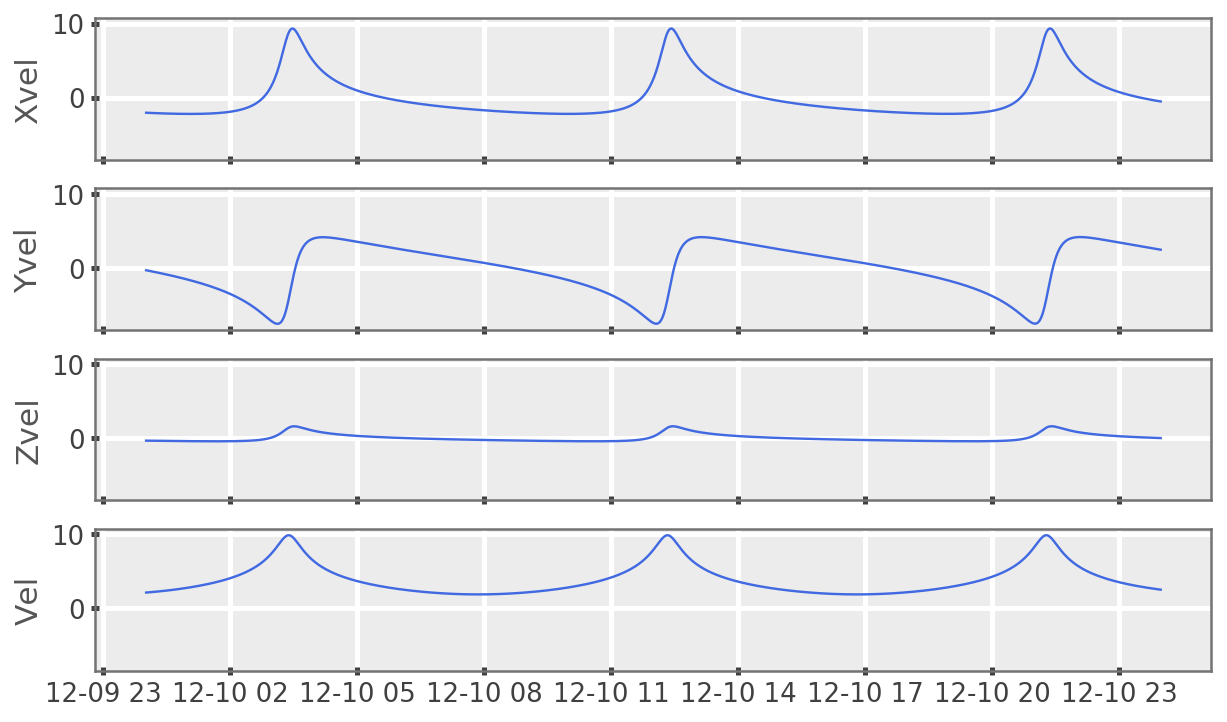

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=1, nrows=3, sharex=True)

ax1.plot(DTs, pos[:,0]/WGS84_A)
ax1.set_ylabel('Xpos')
ax2.plot(DTs, pos[:,1]/WGS84_A)
ax2.set_ylabel('Ypos')
ax3.plot(DTs, pos[:,2]/WGS84_A)
ax3.set_ylabel('Zpos')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=1, nrows=4, 
                                         sharex=True, sharey=True)

ax1.plot(DTs, vel[:,0])
ax1.set_ylabel('Xvel')
ax2.plot(DTs, vel[:,1])
ax2.set_ylabel('Yvel')
ax3.plot(DTs, vel[:,2])
ax3.set_ylabel('Zvel')
ax4.plot(DTs, norm(vel, axis=1))
ax4.set_ylabel('Vel')


## Get the rotations into RBSP_SCIENCE then into RBSP_A_HOPE

In [18]:
# need rotation matrix from RBSPA_SPACECRAFT to RBSPA_SCIENCE at each step
def get_RBSP_SCIENCE_vel(spicet, sat='RBSP_A'):
    # first get the rotations from RBSPA_SPACECRAFT to RBSPA_SCIENCE
    rotations = np.empty((len(spicet), 3, 3), dtype=float)
    for ii, val in enumerate(tqdm.tqdm(spicet)):
        rotations[ii] = spice.pxform('J2000', 
                                     '{0}_SCIENCE'.format(sat.replace('_', '')),
                                     val)
    # get the velocities in RBSPA_SPACECRAFT
    pos, vel, lt = get_pv(ETs['Epoch_Ion'], sat=sat)
    # rotate the velocity into RBSPA_SCIENCE
    v_sci = np.zeros_like(vel)    
    v_sci = np.einsum('ij,ijk->ik',vel,rotations)
    return v_sci


v_sci = get_RBSP_SCIENCE_vel(ETs['Epoch_Ion'])
v_sci[0], v_sci[100], v_sci.shape

100%|██████████| 3474/3474 [00:00<00:00, 22950.23it/s]


(array([-1.68370766,  0.99401607, -0.77218568]),
 array([-0.47538205,  0.43213007,  2.44104598]),
 (3474, 3))

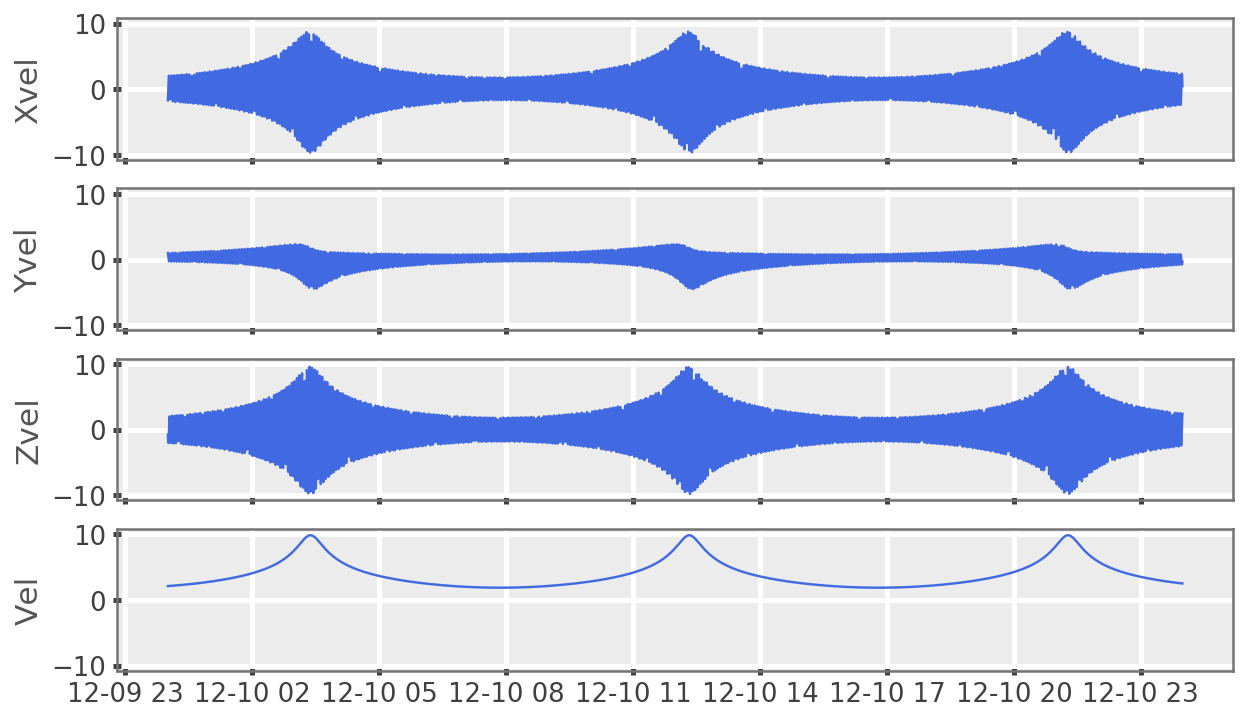

In [19]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=1, nrows=4, sharex=True, sharey=True)

ax1.plot(DTs, v_sci[:,0])
ax1.set_ylabel('Xvel')
ax2.plot(DTs, v_sci[:,1])
ax2.set_ylabel('Yvel')
ax3.plot(DTs, v_sci[:,2])
ax3.set_ylabel('Zvel')
ax4.plot(DTs, norm(v_sci, axis=1))
ax4.set_ylabel('Vel');

### The rotate the RBSPA_SCIENCE frame into each HOPE pixel

In [20]:
# rotations from UVW to HOPE (UVW is RBSPA_SCIENCE in spice)
# These are taken from the HOPE Pitch angle code

# these have to be transposed because SPICE does rotation matrices
# indexed by [output dimension, input dimension]
# where lanlgeomag indexed by [input, output]

def get_HOPE_rotations():
    hope1_rot = np.matrix([[0.30432233, 0.17364818, 0.93660783],
                           [-0.05366024, 0.98480775, -0.16514923],
                           [-0.95105652, 0., 0.30901699]]).transpose()
    hope2_rot = np.matrix([[0.79672621, 0.17364818, 0.57885547],
                           [-0.14048433, 0.98480775, -0.10206784],
                           [-0.58778525, 0., 0.80901699]]).transpose()
    # 80 degree rotation around z
    hope3_rot = np.matrix([[0.98480775, 0.17364818, 0.],
                           [-0.17364818, 0.98480775, 0.],
                           [0., 0., 1.]]).transpose()
    hope4_rot = np.matrix([[0.79672621, 0.17364818, -0.57885547],
                           [-0.14048433, 0.98480775, 0.10206784],
                           [0.58778525, 0., 0.80901699]]).transpose()
    hope5_rot = np.matrix([[0.30432233, 0.17364818, -0.93660783],
                           [-0.05366024, 0.98480775, 0.16514923],
                           [0.95105652, 0., 0.30901699]]).transpose()

    rots = (hope1_rot, hope2_rot, hope3_rot, hope4_rot, hope5_rot)
    rotnp = np.asarray(rots)
    # we don't need below this but it is there, leave it for now
    # spin axis is omega
    # compute omega in uvw
    sc_uvw_rot = np.matrix([[0.81915204, -0.57357644, 0.],
                            [0.57357644, 0.81915204, 0.],
                            [-0., 0., 1.]])
    # omega is along Z in xyz and uvw!!  But leave this in for tuning
    omega_uvw = np.asarray((np.array([0, 0, 1]) * sc_uvw_rot))[0]
    return rots


In [21]:
def rotate_vsci_to_hope(v_sci):
    rots = get_HOPE_rotations()
    pixel_velocities = np.empty((len(v_sci), 3, 5), dtype=float)
    for pixel in tqdm.tqdm(range(5)):
        pixel_velocities[:,:,pixel] = np.asarray(v_sci*rots[pixel])
    return pixel_velocities
p_v = rotate_vsci_to_hope(v_sci)
p_v.shape

100%|██████████| 5/5 [00:00<00:00, 6391.81it/s]


(3474, 3, 5)

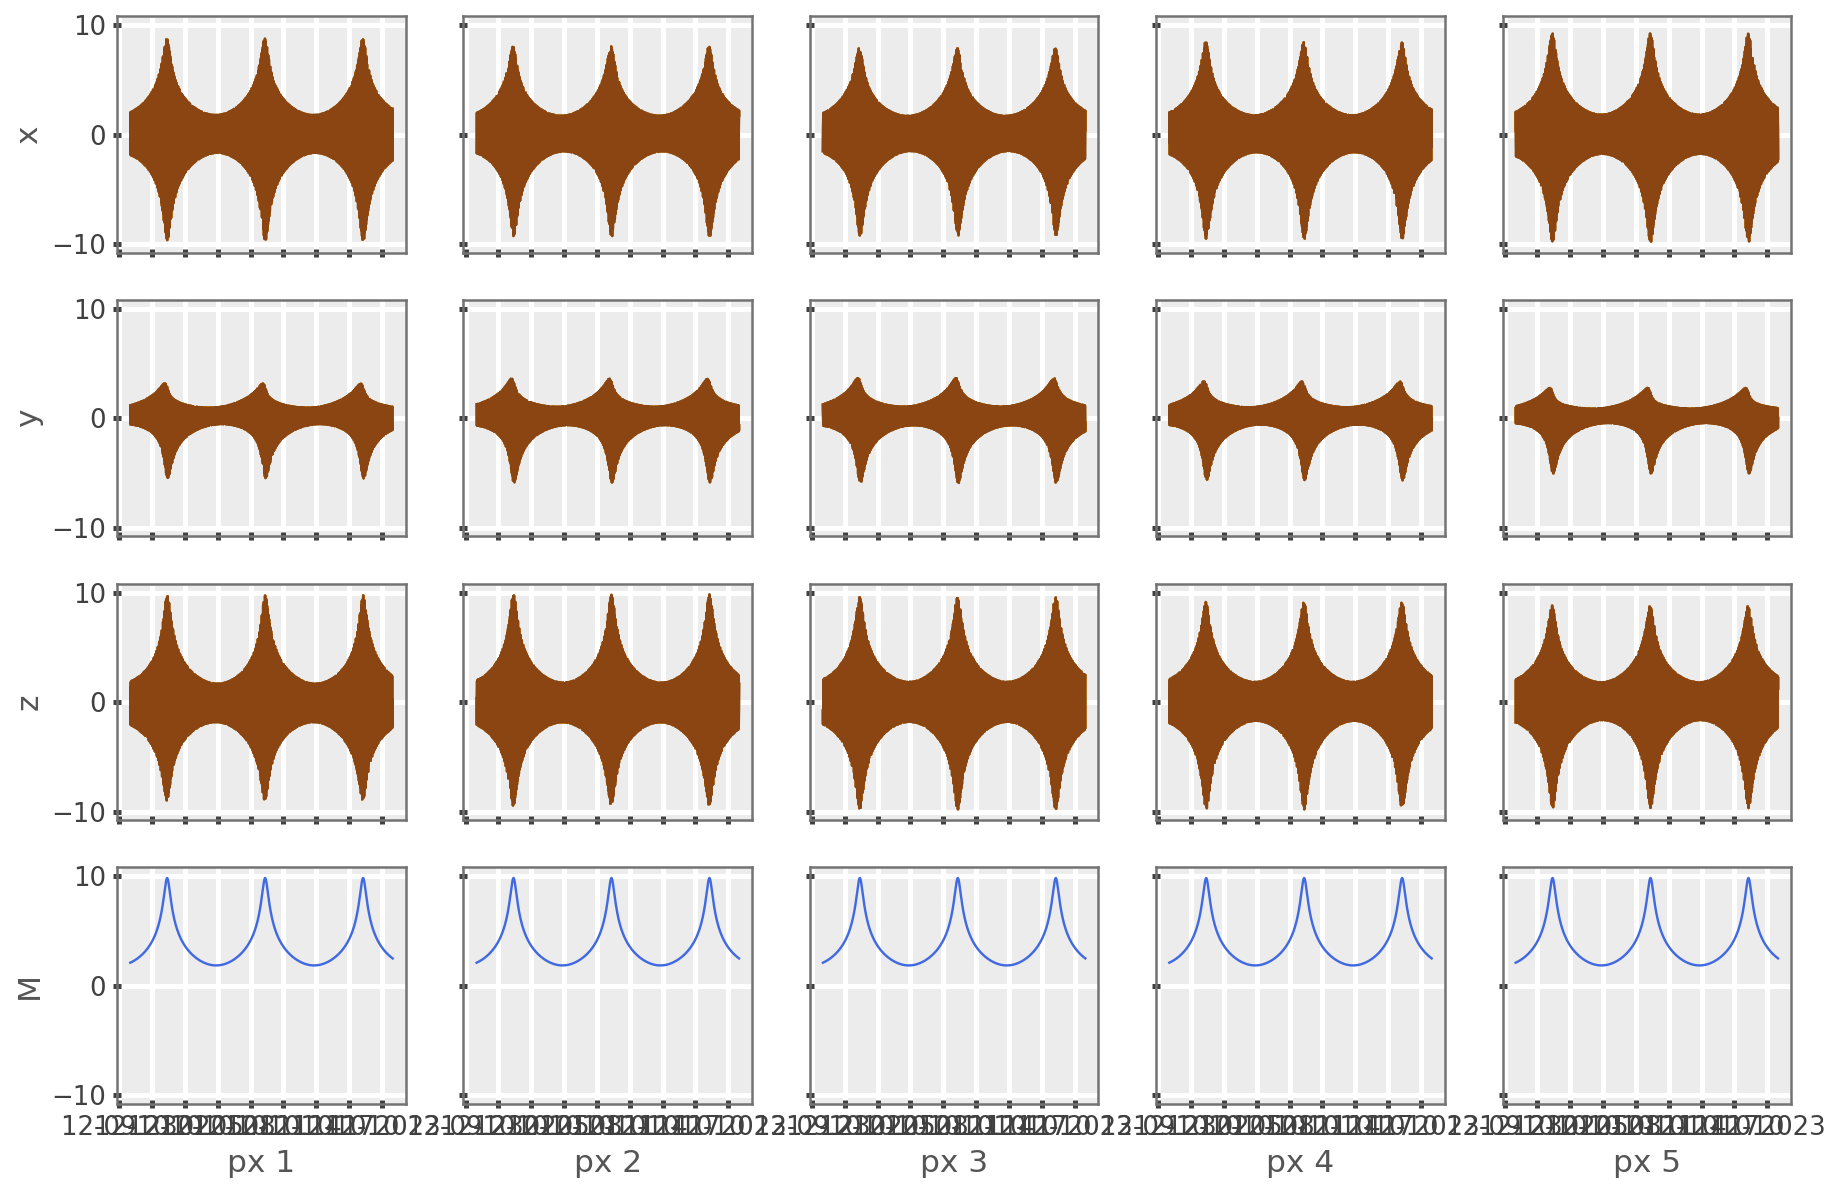

In [22]:
def plot_pixel_v_components(time, p_v):
    fig, ax = plt.subplots(ncols=5, nrows=4, sharex=True, sharey=True, figsize=(15,10))
    components = ('x', 'y', 'z', 'M')

    for comp in range(4):
        for pix in range(5):
            if comp < 3:
                ax[comp][pix].plot(time, p_v[:,comp,pix])
                ax[comp][pix].plot(time, p_v[:,comp,pix])
                ax[comp][pix].plot(time, p_v[:,comp,pix])
                ax[comp][pix].plot(time, p_v[:,comp,pix])
                ax[comp][pix].plot(time, p_v[:,comp,pix])
            else:
                ax[comp][pix].plot(time, norm(p_v[:,:,pix], axis=1))
            ax[-1][pix].set_xlabel('px {0}'.format(pix+1))
        ax[comp][0].set_ylabel('{0}'.format(components[comp]))
    return fig, ax
    
fig, ax = plot_pixel_v_components(DTs, p_v)

(736308.1666666666, 736308.1805555555)

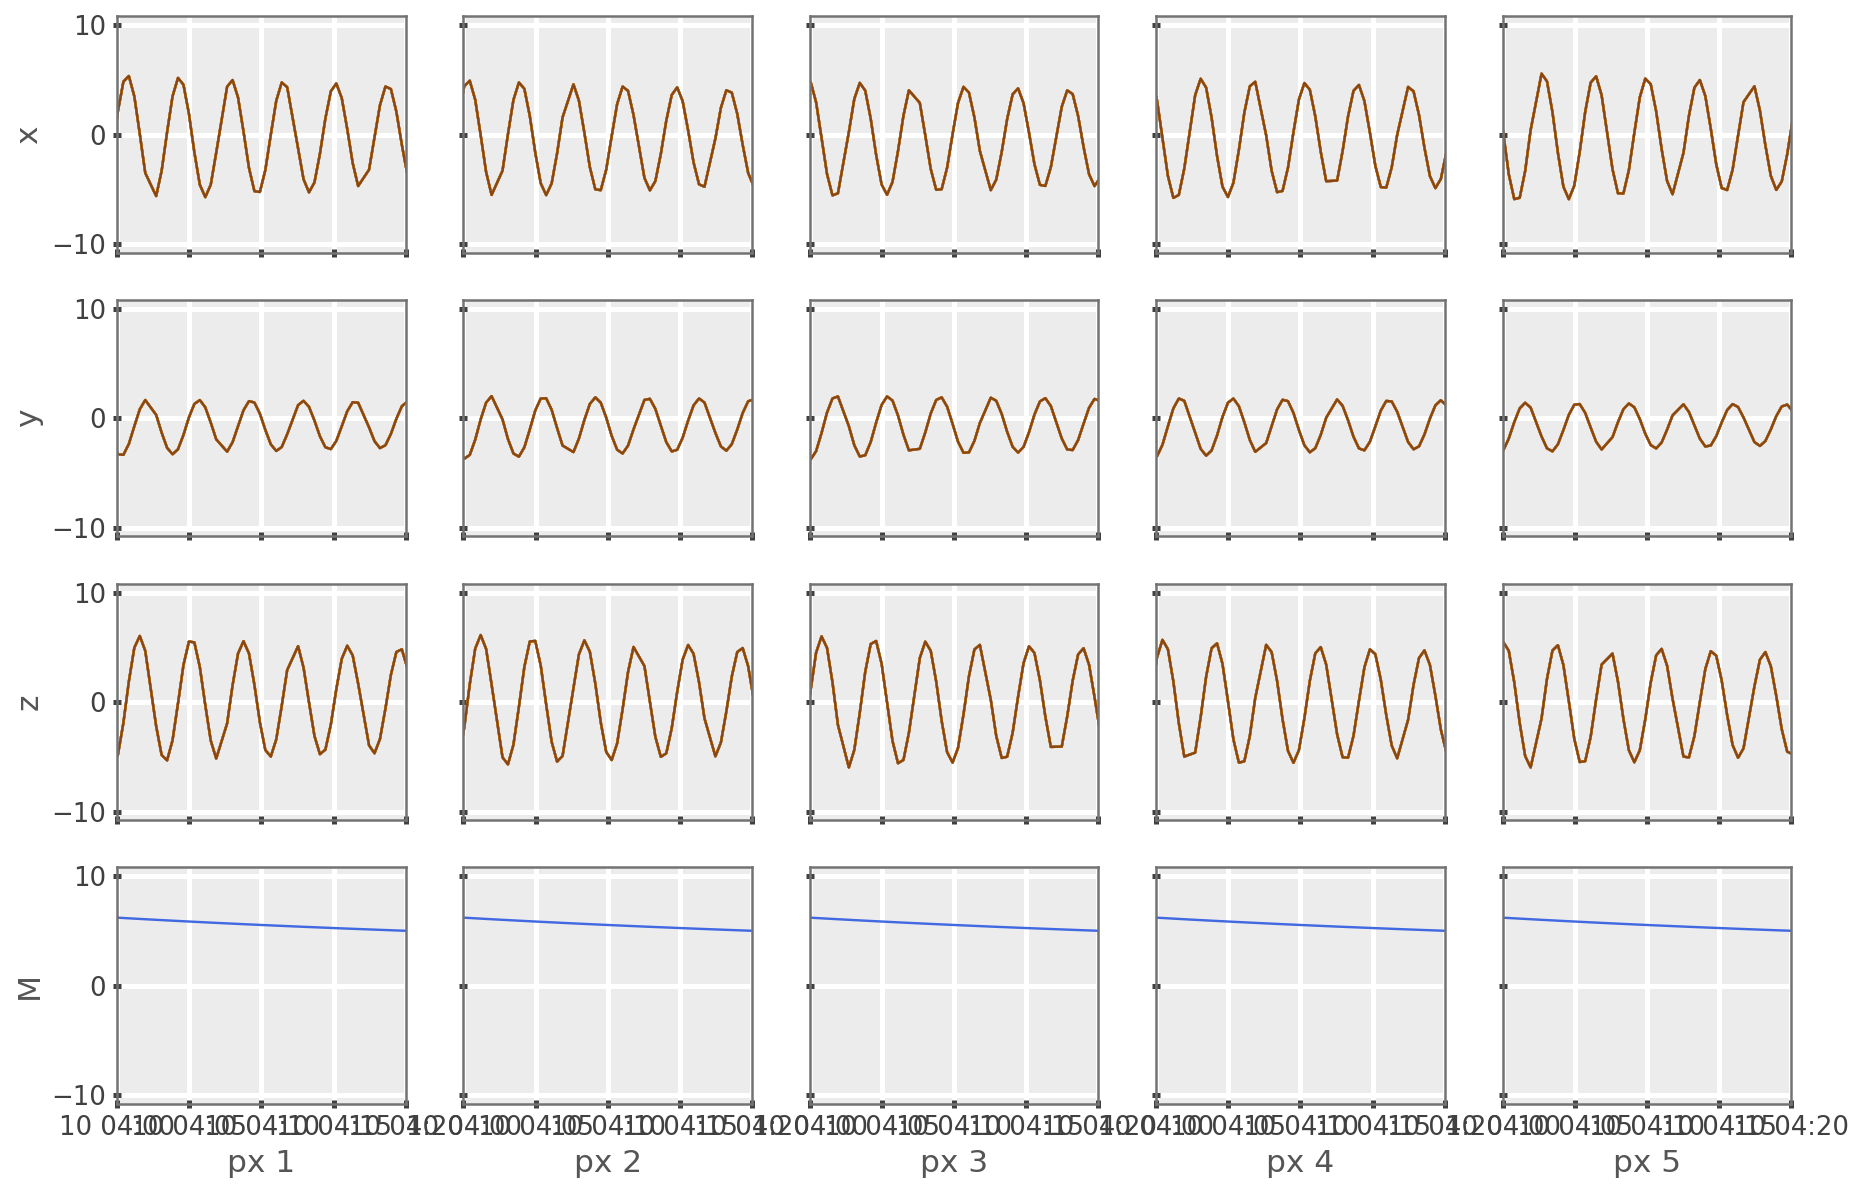

In [23]:
fig, ax = plot_pixel_v_components(DTs, p_v)
plt.xlim((datetime.datetime(2016, 12, 10, 4), datetime.datetime(2016, 12, 10, 4, 20)))

### Apply velocity correction to the energy by species

$E=\frac{1}{2}mv^2$

$v=\sqrt{\frac{2E}{m}}$

The unit vectors for each telescope is $[1,0,0]$ pointed out of the telescope. In the pitch angle code there is a -1 because particles go into telescopes. We will have to work to validate this here to make sure we have the right sign and not off by 180. 

In [24]:
# convert the v_Sci into an energy correction

v_sci = get_RBSP_SCIENCE_vel(ETs['Epoch_Ion'])
p_v = rotate_vsci_to_hope(v_sci)
e_corr = kms_to_e(p_v)
print(v_sci.shape, p_v.shape, e_corr.shape)
# then we only need the x-component of the E correction as that is into the aperature
e_corr = {'H':kms_to_e(p_v, species='H')[:, 0, :], 
         'He':kms_to_e(p_v, species='He')[:, 0, :], 
         'O':kms_to_e(p_v, species='O')[:, 0, :]}
print(v_sci.shape, p_v.shape, e_corr['H'].shape)
tb.dictree(e_corr, verbose=True)

100%|██████████| 5/5 [00:00<00:00, 6905.34it/s]

(3474, 3) (3474, 3, 5) (3474, 3, 5)
(3474, 3) (3474, 3, 5) (3474, 5)
+
|____H (numpy.ndarray (3474, 5))
|____He (numpy.ndarray (3474, 5))
|____O (numpy.ndarray (3474, 5))


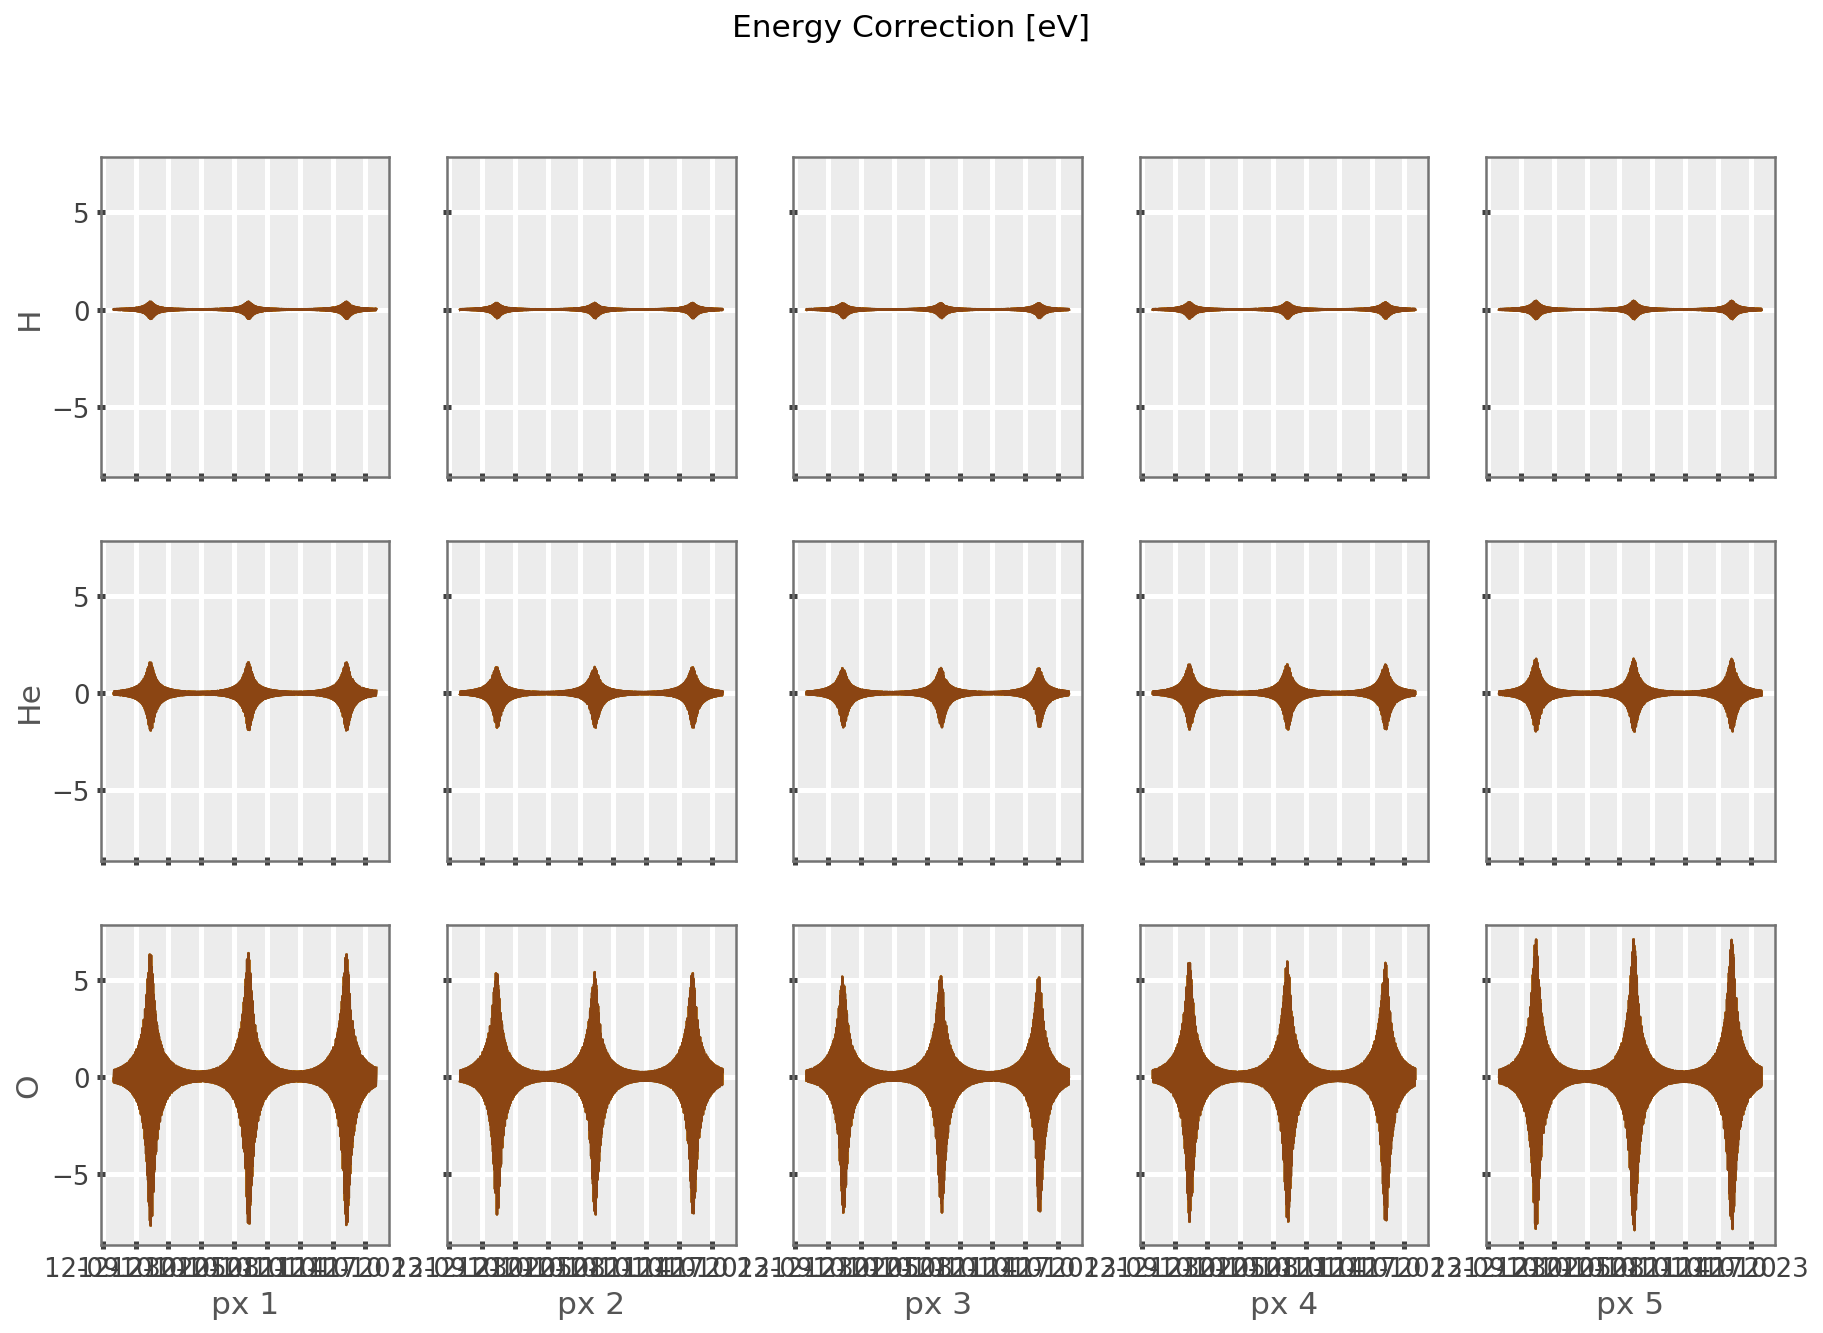

In [25]:
def plot_e_correction(time, e_corr):
    fig, ax = plt.subplots(ncols=5, nrows=3, sharex=True, sharey=True, figsize=(15,10))
    for sp_i, k in enumerate(e_corr):
        ax[sp_i][0].set_ylabel('{0}'.format(k))
        for pix in range(5):
            ax[sp_i][pix].plot(time, e_corr[k][:,pix])
            ax[sp_i][pix].plot(time, e_corr[k][:,pix])
            ax[sp_i][pix].plot(time, e_corr[k][:,pix])
            ax[sp_i][pix].plot(time, e_corr[k][:,pix])
            ax[sp_i][pix].plot(time, e_corr[k][:,pix])
            ax[-1][pix].set_xlabel('px {0}'.format(pix+1))
    plt.suptitle('Energy Correction [eV]')
    return fig, ax
    
fig, ax = plot_e_correction(DTs, e_corr)

In [26]:
e_corr.keys(), e_corr['H'].shape

(dict_keys(['H', 'He', 'O']), (3474, 5))

# End to end class

In [27]:
class EnergyCorrection(object):
    def __init__(self, l2filename):
        """
        l2filename: name of a HOPE 
        """

In [28]:
1/0

ZeroDivisionError: division by zero

In [ ]:
L1cdf = pycdf.CDF(l1fname)

TagTimes = dm.SpaceData()


# raw read the Epoch!!  This is faster and in milliseconds so no conversion needed
epoch16 = L1cdf.raw_var('Epoch_Ion_Cntr_H')[...]
# (3879,)
TagTimes['Epoch_Ion'] = dm.dmarray([pycdf.lib.epoch16_to_epoch(v) for v in epoch16])
TagTimes['Epoch_Ion'].attrs = L1cdf['Epoch_Ion_Cntr_H'].attrs.copy()

# if they are actually all the same no need to cycle through here
if (L1cdf['FRAME_subtime'][:, 0, 0] != L1cdf['FRAME_subtime'][:, 0, 0][0]).any():
    raise(NotImplementedError("L1cdf['FRAME_subtime'] has different values, not sure what to do"))

TagTimes['Epoch_Ion_FRAME_subtime'] = L1cdf['FRAME_subtime'][0, :, :].copy()
# (16, 72)
# L2cdf['FEDU'] CDF_REAL4 [3879, 5, 16, 72]
## multiply TagTimes['Epoch_Ion_FRAME_subtime'] by 1000 to make it a Epoch (milliseconds)
TagTimes['Epoch_Ion_FRAME_subtime'] *= 1000

## make the full times as Epochs
# Full times needs [epoch][sector][energy]  NO PIXEL!!
# factor of 4 in time by not having it be [pixel] also (8 to 2 seconds)
# also cdf is 140M smaller!!!
TagTimes['Full_times_Ion'] = np.empty((L1cdf['Ion_Cntr_H'].shape[0],
                                       L1cdf['Ion_Cntr_H'].shape[2],
                                       L1cdf['Ion_Cntr_H'].shape[3]), dtype=np.float64)

for ii, epoch in enumerate(TagTimes['Epoch_Ion']):
    TagTimes['Full_times_Ion'][ii] = epoch + TagTimes['Epoch_Ion_FRAME_subtime']
